# Latex  数据

In [96]:
%matplotlib inline
from IPython.display import Latex
from pytexit import py2tex
from PIL import Image
import numpy as np 
from matplotlib import pyplot as plt 
import io

# ss = py2tex(r'sqrt(2/2 + 100)')
# print('ss ->', ss)
# Latex(ss)
# 下载 anltr https://www.cnblogs.com/solvit/p/10097234.html,
# 执行 antlr4 PS.g4 -o gen 生成解释代码  https://github.com/augustt198/latex2sympy
# import sympy
# sympy.simplify('sqrt(2/2-0.5)')
#注意 sympy开根号不显示无理数，只会sqrt方式显示。比如8–√=22–√8 ​=22​

# latex 转图稿保存
fig = plt.figure(figsize=(8,8))

def latex_to_img(tex, family='serif'):
    buf = io.BytesIO()
    plt.axis('off')
    plt.rc('text', usetex=False)
# params = {'mathtext.fontset': 'stixsans'}
# plt.rcParams.update(params)    
    # ['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
    plt.rc('mathtext',fontset='cm')
#     plt.rc('mathtext',default='regular')
    plt.rc('font', family=family)
    plt.text(0.5, 0.5, r"$%s$" % tex,fontsize = 40, ha='center', va='center')
    plt.savefig(buf,format='png',transparent=False,pad_inches=0,dpi=300)
    plt.close()
    image = Image.open(buf)
    return image

def image_ract(image_array):
    x_array, y_array = np.where(image_array==1)
    return x_array[np.argmin(x_array)] -2 , y_array[np.argmin(y_array)] -2 , x_array[np.argmax(x_array)] + 2, y_array[np.argmax(y_array)] + 2

def get_latex_image(tex,family='serif'):
    image = latex_to_img(tex,family)
    image_array = np.array(image.copy().convert("L"))
    image_array_new = 1 - image_array/255 
    x1,y1,x2,y2 = image_ract(image_array_new)
    image = image.crop((y1,x1,y2,x2))
    image = image.convert('RGB')
    return image
    


<Figure size 576x576 with 0 Axes>

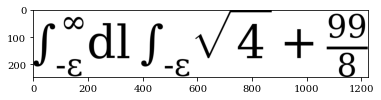

In [99]:
latex ='\\int _ { - \\epsilon } ^ { \\infty } d l \\:  \\int _ { - \\epsilon }  \\sqrt { 4  } + \\frac { 99 } { 8 } '
# latex = '\\sqrt { 4  } + \\frac { 9 } { 8 }'
image = get_latex_image(latex)
plt.imshow(image)
plt.show()

In [36]:
# 生成训练，测试数据
# https://haolaoshi.blog.csdn.net/article/details/89531570 Latex四则运算符号
# -*- coding: UTF-8 -*-
from pytexit import py2tex
from random import randint

formul_files = 'D:\\PROJECT_TW\\git\\data\\im2latex\\latex_formul_normal.txt'

fms = ['\\frac {{ {0} }} {{ {1} }} + {{ {2} }}', 
        '{{ {0} }} \\times {{ {1} }} - {2} {3}', 
       '{0} - \\frac {{ {1} ^ {2} }} {{ {3} }} = {4}',
       '\\sqrt {{ {0} {1} }} + \\frac {{ {3} }} {{ {4} }}',
       '{0} \\div {1} \\times \sqrt {{ {2} }} = {3}']

size = 20000
formul_lists = []
for idx in range(len(fms),len(fms)+size):
    fm = fms[idx % len(fms)]
    fm = fm.format(randint(0,9),randint(0,9),randint(0,9),randint(0,9),randint(0,9),randint(0,9),randint(0,9),randint(0,9),randint(0,9))
    fm = fm + '\n'
    formul_lists.append(fm)

with open(formul_files, 'w', encoding='utf8') as f:
    f.writelines(formul_lists)

In [2]:
# 生成图片数据
import os
formul_files = 'D:\\PROJECT_TW\\git\\data\\im2latex\\latex_formul_normal.txt'
formul_image_path = 'D:\\PROJECT_TW\\git\\data\\im2latex\\gen_images'

formul_lists = None
with open(formul_files,'r', encoding='utf8') as f:
    formul_lists = f.readlines()
# print(formul_lists)

for idx in range(len(formul_lists)):
    tex = formul_lists[idx]
    tex = tex.replace('\n','')
#     print('tex:', tex)
#     print('\\frac{8}{6}+{7}')
#     tex = '\\frac{8}{6}+{7}'
    if idx % 1000 == 0:
        print('gen image :', idx)
    image = get_latex_image(tex)
    image.save(os.path.sep.join([formul_image_path,f'{idx}.png']))
    
print('生成图片完成 ')
    


gen image : 0
gen image : 1000
gen image : 2000
gen image : 3000
gen image : 4000
gen image : 5000
gen image : 6000
gen image : 7000
gen image : 8000
gen image : 9000
gen image : 10000
gen image : 11000
gen image : 12000
gen image : 13000
gen image : 14000
gen image : 15000
gen image : 16000
gen image : 17000
gen image : 18000
gen image : 19000
生成图片完成 


In [31]:
image = Image.open('D:\\PROJECT_TW\\git\\data\\im2latex\\gen_images\\0.png')
# image = image.convert('RGB')
image.mode

'RGB'

# 模型

In [1]:
'''
https://github.com/luopeixiang/im2latex
https://blog.csdn.net/SHU15121856/article/details/104448734 nn.LSTM和nn.LSTMCell的使用

'''

import math
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.distributions.uniform import Uniform

def add_positional_features(tensor: torch.Tensor,
                            min_timescale: float = 1.0,
                            max_timescale: float = 1.0e4):
    """
    Implements the frequency-based positional encoding described
    in `Attention is all you Need
    Parameters
    ----------
    tensor : ``torch.Tensor``
        a Tensor with shape (batch_size, timesteps, hidden_dim).
    min_timescale : ``float``, optional (default = 1.0)
        The largest timescale to use.
    Returns
    -------
    The input tensor augmented with the sinusoidal frequencies.
    """
    _, timesteps, hidden_dim = tensor.size()
    timestep_range = get_range_vector(timesteps, tensor.device).data.float()
    # We're generating both cos and sin frequencies,
    # so half for each.
    num_timescales = hidden_dim // 2
    timescale_range = get_range_vector(num_timescales, tensor.device).data.float()

    log_timescale_increments = math.log(float(max_timescale) / float(min_timescale)) / float(num_timescales - 1)
    inverse_timescales = min_timescale * \
        torch.exp(timescale_range * -log_timescale_increments)

    # Broadcasted multiplication - shape (timesteps, num_timescales)
    scaled_time = timestep_range.unsqueeze(1) * inverse_timescales.unsqueeze(0)
    # shape (timesteps, 2 * num_timescales)
    sinusoids = torch.randn(scaled_time.size(0), 2*scaled_time.size(1), device=tensor.device)
    sinusoids[:, ::2] = torch.sin(scaled_time)
    sinusoids[:, 1::2] = torch.cos(scaled_time)
    if hidden_dim % 2 != 0:
        # if the number of dimensions is odd, the cos and sin
        # timescales had size (hidden_dim - 1) / 2, so we need
        # to add a row of zeros to make up the difference.
        sinusoids = torch.cat([sinusoids, sinusoids.new_zeros(timesteps, 1)], 1)
    return tensor + sinusoids.unsqueeze(0)

def get_range_vector(size: int, device) -> torch.Tensor:
    return torch.arange(0, size, dtype=torch.long, device=device)

INIT = 1e-2

class Im2LatexModel(nn.Module):
    def __init__(self, out_size, emb_size, dec_rnn_h,
                 enc_out_dim=512,  n_layer=1,
                 add_pos_feat=False, dropout=0.):
        super(Im2LatexModel, self).__init__()

        self.cnn_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 1),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 1),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1), 0),

            nn.Conv2d(256, enc_out_dim, 3, 1, 0),
            nn.ReLU()
        )
        self.rnn_decoder = nn.LSTMCell(dec_rnn_h+emb_size, dec_rnn_h)
        self.embedding = nn.Embedding(out_size, emb_size)

        self.init_wh = nn.Linear(enc_out_dim, dec_rnn_h)
        self.init_wc = nn.Linear(enc_out_dim, dec_rnn_h)
        self.init_wo = nn.Linear(enc_out_dim, dec_rnn_h)

        # Attention mechanism
        self.beta = nn.Parameter(torch.Tensor(enc_out_dim))
        init.uniform_(self.beta, -INIT, INIT)
        self.W_1 = nn.Linear(enc_out_dim, enc_out_dim, bias=False)
        self.W_2 = nn.Linear(dec_rnn_h, enc_out_dim, bias=False)

        self.W_3 = nn.Linear(dec_rnn_h+enc_out_dim, dec_rnn_h, bias=False)
        self.W_out = nn.Linear(dec_rnn_h, out_size, bias=False)

        self.add_pos_feat = add_pos_feat
        self.dropout = nn.Dropout(p=dropout)
        self.uniform = Uniform(0, 1)

    def forward(self, imgs, formulas, epsilon=1.):
        """args:
        imgs: [B, C, H, W]
        formulas: [B, MAX_LEN]
        epsilon: probability of the current time step to  use the true previous token
        return:
        logits: [B, MAX_LEN, VOCAB_SIZE]
        """
        # encoding
        encoded_imgs = self.encode(imgs)  # [B, H*W, 512]
        # init decoder's states  ？？？？？？？？？？
        dec_states, o_t = self.init_decoder(encoded_imgs)
        max_len = formulas.size(1)
        logits = []
        for t in range(max_len):
            tgt = formulas[:, t:t+1]
            # schedule sampling
            if logits and self.uniform.sample().item() > epsilon:
                tgt = torch.argmax(torch.log(logits[-1]), dim=1, keepdim=True)
            # ont step decoding
            dec_states, O_t, logit = self.step_decoding(dec_states, o_t, encoded_imgs, tgt)
            logits.append(logit)
        logits = torch.stack(logits, dim=1)  # [B, MAX_LEN, out_size]
        return logits

    def encode(self, imgs):
        encoded_imgs = self.cnn_encoder(imgs)  # [B, 512, H', W']
        encoded_imgs = encoded_imgs.permute(0, 2, 3, 1)  # [B, H', W', 512]
        B, H, W, _ = encoded_imgs.shape
        encoded_imgs = encoded_imgs.contiguous().view(B, H*W, -1)
        if self.add_pos_feat:
            encoded_imgs = add_positional_features(encoded_imgs)
        return encoded_imgs

    
    def step_decoding(self, dec_states, o_t, enc_out, tgt):
        """
            Runing one step decoding
            dec_states : (h_t, c_t)
            o_t: atten scores
            enc_out: pre logits
            tgt: pre true target
        """

        prev_y = self.embedding(tgt).squeeze(1)  # [B, emb_size]
        inp = torch.cat([prev_y, o_t], dim=1)  # [B, emb_size+dec_rnn_h]
        h_t, c_t = self.rnn_decoder(inp, dec_states)  # h_t:[B, dec_rnn_h]
        h_t = self.dropout(h_t)
        c_t = self.dropout(c_t)

        # context_t : [B, C]
        context_t, attn_scores = self._get_attn(enc_out, h_t)

        # [B, dec_rnn_h]
        o_t = self.W_3(torch.cat([h_t, context_t], dim=1)).tanh()
        o_t = self.dropout(o_t)

        # calculate logit
        logit = F.softmax(self.W_out(o_t), dim=1)  # [B, out_size]

        return (h_t, c_t), o_t, logit

    def _get_attn(self, enc_out, h_t):
        """Attention mechanism
        args:
            enc_out: row encoder's output [B, L=H*W, C]
            h_t: the current time step hidden state [B, dec_rnn_h]
        return:
            context: this time step context [B, C]
            attn_scores: Attention scores
        """
        # cal alpha
        alpha = torch.tanh(self.W_1(enc_out)+self.W_2(h_t).unsqueeze(1))
        alpha = torch.sum(self.beta*alpha, dim=-1)  # [B, L]
        alpha = F.softmax(alpha, dim=-1)  # [B, L]

        # cal context: [B, C]
        context = torch.bmm(alpha.unsqueeze(1), enc_out)
        context = context.squeeze(1)
        return context, alpha

    def init_decoder(self, enc_out):
        """args:
            enc_out: the output of row encoder [B, H*W, C]
          return:
            h_0, c_0:  h_0 and c_0's shape: [B, dec_rnn_h]
            init_O : the average of enc_out  [B, dec_rnn_h]
            for decoder
        """
        mean_enc_out = enc_out.mean(dim=1)
        h = self._init_h(mean_enc_out)
        c = self._init_c(mean_enc_out)
        init_o = self._init_o(mean_enc_out)
        return (h, c), init_o

    def _init_h(self, mean_enc_out):
        return torch.tanh(self.init_wh(mean_enc_out))

    def _init_c(self, mean_enc_out):
        return torch.tanh(self.init_wc(mean_enc_out))

    def _init_o(self, mean_enc_out):
        return torch.tanh(self.init_wo(mean_enc_out))


# 数据预处理

In [6]:
# 执行 build_vocab 生成latex 向量表
import lib.im2latex.preprocess as pre 
import lib.im2latex.build_vocab as bv
import importlib
from os.path import join
importlib.reload(pre)
importlib.reload(bv)
size = 1000
splits = ["validate", "test", "train"]
data_path = 'D:\\PROJECT_TW\\git\\data\\im2latex'

def write_filter_data(split, datas):
    split_file = join(data_path, "latex_{}_filter.txt".format(split))
    with open(split_file,'w') as f:
        wdatas = [f'{x}\n' for x in datas]
        f.writelines(wdatas)
# bv.build_vocab(data_path)
train_data = [f'{x}.png {x}' for x in range(18000)]
valid_data = [f'{x}.png {x}' for x in range(18000,19000)]
test_data = [f'{x}.png {x}' for x in range(19000,20000)]
write_filter_data('train', train_data)
write_filter_data('validate', valid_data)
write_filter_data('test', test_data)
pre.preprocess(data_path,'train')
pre.preprocess(data_path,'validate')
pre.preprocess(data_path,'test')
bv.build_vocab(data_path)

Process train dataset...
D:\PROJECT_TW\git\data\im2latex\latex_train_filter.txt
Save train dataset to D:\PROJECT_TW\git\data\im2latex\train.pkl
Process validate dataset...
D:\PROJECT_TW\git\data\im2latex\latex_validate_filter.txt
Save validate dataset to D:\PROJECT_TW\git\data\im2latex\validate.pkl
Process test dataset...
D:\PROJECT_TW\git\data\im2latex\latex_test_filter.txt
Save test dataset to D:\PROJECT_TW\git\data\im2latex\test.pkl
Writing Vocab File in  D:\PROJECT_TW\git\data\im2latex\vocab.pkl len : 24


In [6]:
# 加载gc模块
import gc
gc.collect()

20

# 训练

In [2]:
import os
from os.path import join
import torch
from torch.nn.utils import clip_grad_norm_
from lib.im2latex.utils import cal_loss, cal_epsilon
import gc

class Trainer(object):
    def __init__(self, optimizer, model, lr_scheduler,
                 train_loader, val_loader, args,
                 use_cuda=False, init_epoch=1, last_epoch=15):
        self.optimizer = optimizer
        self.model = model
        self.lr_scheduler = lr_scheduler
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.args = args
        self.step = 0
        self.epoch = init_epoch
        self.total_step = (init_epoch-1)*len(train_loader)
        self.last_epoch = last_epoch
        self.best_val_loss = 1e18
        self.device = torch.device("cuda" if use_cuda else "cpu")

    def train(self):
        mes = "Epoch {}, step:{}/{} {:.2f}%, Loss:{:.4f}, Perplexity:{:.4f}"
        self.last_epoch = 1000
        args.print_freq = 25
        print('max epoch --> ', self.last_epoch,  ' print freq:', args.print_freq)
        while self.epoch <= self.last_epoch:
            self.model.train()
            losses = 0.0
            #  tgt4training 字符串开始标记<s>, tgt4cal_loss 字符串结束标记</s>    
            for imgs, tgt4training, tgt4cal_loss in self.train_loader:
                step_loss = self.train_step(imgs, tgt4training, tgt4cal_loss)
                losses += step_loss

                # log message
                if self.step % self.args.print_freq == 0:
                    avg_loss = losses / self.args.print_freq
                    print(mes.format(
                        self.epoch, self.step, len(self.train_loader),
                        100 * self.step / len(self.train_loader),
                        avg_loss,
                        2**avg_loss
                    ))
                    losses = 0.0
                    gc.collect()

            # one epoch Finished, calcute val loss
            val_loss = self.validate()
            self.lr_scheduler.step(val_loss)

            self.save_model('ckpt-{}-{:.4f}'.format(self.epoch, val_loss))
            self.epoch += 1
            self.step = 0

    def train_step(self, imgs, tgt4training, tgt4cal_loss):
        self.optimizer.zero_grad()
        imgs = imgs.to(self.device)
        tgt4training = tgt4training.to(self.device)
        tgt4cal_loss = tgt4cal_loss.to(self.device)

        '''
        Scheduled Sampling for Sequence Prediction with Recurrent Neural Networks
        See details in https://arxiv.org/pdf/1506.03099.pdf
        '''
        epsilon = cal_epsilon(self.args.decay_k, self.total_step, self.args.sample_method)

        '''
        https://www.zhihu.com/question/60751553 如何理解深度学习源码里经常出现的logits？
        logits: 一个事件发生与该事件不发生的比值的对数（统计学习方法-李航 p78）。假设一个事件发生的概率为 p，那么该事件的 logits 为 logit(p) = log(p/1-p) .
        '''
        logits = self.model(imgs, tgt4training, epsilon)

        
        # calculate loss
        loss = cal_loss(logits, tgt4cal_loss)
        self.step += 1
        self.total_step += 1
        loss.backward()
        clip_grad_norm_(self.model.parameters(), self.args.clip)
        self.optimizer.step()
        return loss.item()

    def validate(self):
        self.model.eval()
        val_total_loss = 0.0
        mes = "Epoch {}, validation average loss:{:.4f}, Perplexity:{:.4f}"
        with torch.no_grad():
            for imgs, tgt4training, tgt4cal_loss in self.val_loader:
                imgs = imgs.to(self.device)
                tgt4training = tgt4training.to(self.device)
                tgt4cal_loss = tgt4cal_loss.to(self.device)

                epsilon = cal_epsilon(
                    self.args.decay_k, self.total_step, self.args.sample_method)
                logits = self.model(imgs, tgt4training, epsilon)
                loss = cal_loss(logits, tgt4cal_loss)
                val_total_loss += loss
            avg_loss = val_total_loss / len(self.val_loader)
            print(mes.format(
                self.epoch, avg_loss, 2**avg_loss
            ))
#             print('predict:',logits)
#             print('result:',tgt4cal_loss)
            
        if avg_loss < self.best_val_loss:
            self.best_val_loss = avg_loss
            self.save_model('best_ckpt')
        return avg_loss

    def save_model(self, model_name):
        if not os.path.isdir(self.args.save_dir):
            os.makedirs(self.args.save_dir)
        save_path = join(self.args.save_dir, model_name+'.pt')
        print("Saving checkpoint to {}".format(save_path))

        # torch.save(self.model, model_path)

        torch.save({
            'epoch': self.epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'lr_sche': self.lr_scheduler.state_dict(),
            'epoch': self.epoch,
            'args': self.args
        }, save_path)


In [3]:
import argparse
from functools import partial

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from lib.im2latex.utils import collate_fn, get_checkpoint
from lib.im2latex.data import Im2LatexDataset
from lib.im2latex.build_vocab import Vocab, load_vocab
def init_loader():
    # get args
    parser = argparse.ArgumentParser(description="Im2Latex Training Program")
    # parser.add_argument('--path', required=True, help='root of the model')
    # model args
    parser.add_argument("--emb_dim", type=int, default=80, help="Embedding size")
    parser.add_argument("--dec_rnn_h", type=int, default=512, help="The hidden state of the decoder RNN")
    parser.add_argument("--data_path", type=str, default="D:\\PROJECT_TW\\git\\data\\im2latex", help="The dataset's dir")
    parser.add_argument("--add_position_features", action='store_true', default=True, help="Use position embeddings or not")
    # training args
    parser.add_argument("--max_len", type=int, default=150, help="Max size of formula")
    parser.add_argument("--dropout", type=float,default=0., help="Dropout probility")
    parser.add_argument("--cuda", action='store_true',default=True, help="Use cuda or not")
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument("--epoches", type=int, default=200)
    parser.add_argument("--lr", type=float, default=3e-4,help="Learning Rate")
    parser.add_argument("--min_lr", type=float, default=3e-5, help="Learning Rate")
    parser.add_argument("--sample_method", type=str, default="teacher_forcing", choices=('teacher_forcing', 'exp', 'inv_sigmoid'), help="The method to schedule sampling")
    parser.add_argument("--decay_k", type=float, default=1.,
                        help="Base of Exponential decay for Schedule Sampling. "
                        "When sample method is Exponential deca;"
                        "Or a constant in Inverse sigmoid decay Equation. "
                        "See details in https://arxiv.org/pdf/1506.03099.pdf")
    parser.add_argument("--lr_decay", type=float, default=0.5, help="Learning Rate Decay Rate")
    parser.add_argument("--lr_patience", type=int, default=3,  help="Learning Rate Decay Patience")
    parser.add_argument("--clip", type=float, default=2.0, help="The max gradient norm")
    parser.add_argument("--save_dir", type=str, default="D:\\PROJECT_TW\\git\\data\\im2latex\\ckpts", help="The dir to save checkpoints")
    parser.add_argument("--print_freq", type=int, default=100, help="The frequency to print message")
    parser.add_argument("--seed", type=int, default=2020, help="The random seed for reproducing ")
    parser.add_argument("--from_check_point", action='store_true', default=False, help="Training from checkpoint or not")
    #  注意在 jupyter notebook 需带args=[] 这个参数
    args = parser.parse_args(args=[])
    
    from_check_point = args.from_check_point
    if from_check_point:
        checkpoint_path = get_checkpoint(args.save_dir)
        checkpoint = torch.load(checkpoint_path)
        args = checkpoint['args']
    args.epoches=200
    args.from_check_point = True
    max_epoch = args.epoches
    print("Training args:", args)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    # Building vocab
    print("Load vocab...")
    vocab = load_vocab(args.data_path)
#     print('vocab -->', vocab.sign2id)
    use_cuda = True if args.cuda and torch.cuda.is_available() else False
    device = torch.device("cuda" if use_cuda else "cpu")

    # data loader
    print("Construct data loader...")
#     train_loader = None
    train_loader = DataLoader(
        Im2LatexDataset(args.data_path, 'train', args.max_len),
        batch_size=args.batch_size,
        collate_fn=partial(collate_fn, vocab.sign2id),
        pin_memory=True if use_cuda else False,
        num_workers=1)
    val_loader = DataLoader(
        Im2LatexDataset(args.data_path, 'validate', args.max_len),
        batch_size=args.batch_size,
        collate_fn=partial(collate_fn, vocab.sign2id),
        pin_memory=True if use_cuda else False,
        num_workers=1)
    print("Construct data loader over")
    return train_loader, val_loader,vocab, args

def train(train_loader,val_loader, vocab, args):
    use_cuda = True if args.cuda and torch.cuda.is_available() else False
    device = torch.device("cuda" if use_cuda else "cpu")    
    # construct model
    print("Construct model")
    vocab_size = len(vocab)
    model = Im2LatexModel(
        vocab_size, args.emb_dim, args.dec_rnn_h,
        add_pos_feat=args.add_position_features,
        dropout=args.dropout
    )
    model = model.to(device)
    print("Model Settings:")
    print(model)  
    # construct optimizer
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    lr_scheduler = ReduceLROnPlateau(
        optimizer,
        "min",
        factor=args.lr_decay,
        patience=args.lr_patience,
        verbose=True,
        min_lr=args.min_lr)    
    
        
    if args.from_check_point:
        print('from check point .. ')
        checkpoint_path = get_checkpoint(args.save_dir)
        checkpoint = torch.load(checkpoint_path)
        args = checkpoint['args']
    
    if args.from_check_point:
        print('from check point .. ')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        lr_scheduler.load_state_dict(checkpoint['lr_sche'])
        max_epoch = args.epoches
        # init trainer from checkpoint
        trainer = Trainer(optimizer, model, lr_scheduler,
                          train_loader, val_loader, args,
                          use_cuda=use_cuda,
                          init_epoch=epoch, last_epoch=max_epoch)
    else:
        trainer = Trainer(optimizer, model, lr_scheduler,
                          train_loader, val_loader, args,
                          use_cuda=use_cuda,
                          init_epoch=1, last_epoch=1000)
    # begin training
    trainer.train()    




In [4]:
# 加载数据
train_loader, val_loader,vocab, args =  init_loader()

Training args: Namespace(add_position_features=True, batch_size=32, clip=2.0, cuda=True, data_path='D:\\PROJECT_TW\\git\\data\\im2latex', dec_rnn_h=512, decay_k=1.0, dropout=0.0, emb_dim=80, epoches=200, from_check_point=True, lr=0.0003, lr_decay=0.5, lr_patience=3, max_len=150, min_lr=3e-05, print_freq=100, sample_method='teacher_forcing', save_dir='D:\\PROJECT_TW\\git\\data\\im2latex\\ckpts', seed=2020)
Load vocab...
Load vocab including 24 words!
Construct data loader...
Construct data loader over


In [5]:
# 开始训练
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 10000})
args.from_check_point=True
args.print_freq=25
train(train_loader, val_loader,vocab, args)


Construct model
Model Settings:
Im2LatexModel(
  (cnn_encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU()
  )
  (rnn_decoder): LSTMCell(592, 512)
  (embedding): Embedding(24, 80)
  (init_wh): Linear(in_features=512, out_features=512, bias=True)
  (init_wc): Linear(in_features=512, out_features=512, bias=True)
  (init_w

KeyboardInterrupt: 

# 评测

In [5]:
from os.path import join
from functools import partial
import argparse
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import lib.im2latex.data as idata # import Im2LatexDataset
from lib.im2latex.build_vocab import Vocab, load_vocab
from lib.im2latex.utils import collate_fn
from lib.im2latex.decoding import LatexProducer
from lib.im2latex.score import score_files
import importlib
importlib.reload(idata)

def evaluate():

    parser = argparse.ArgumentParser(description="Im2Latex Evaluating Program")
    parser.add_argument('--model_path', required=False, help='path of the evaluated model')

    # model args
    parser.add_argument("--data_path", type=str, default="D:\\PROJECT_TW\\git\\data\\im2latex", help="The dataset's dir")
    parser.add_argument("--cuda", action='store_true',default=False, help="Use cuda or not")
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument("--beam_size", type=int, default=5)
    parser.add_argument("--result_path", type=str, default="D:\\PROJECT_TW\\git\\data\\im2latex\\result.txt", help="The file to store result")
    parser.add_argument("--ref_path", type=str, default="D:\\PROJECT_TW\\git\\data\\im2latex\\ref.txt", help="The file to store reference")
    parser.add_argument("--max_len", type=int, default=64, help="Max step of decoding")
    parser.add_argument("--split", type=str,default="validate", help="The data split to decode")

    args = parser.parse_args(args=[])

    # 加载 模型
    model_path = 'D:\\PROJECT_TW\\git\\data\\im2latex\\ckpts\\best_ckpt.pt'
    checkpoint = torch.load(model_path)
    model_args = checkpoint['args']

    # 读入词典,设置其他相关参数
    vocab = load_vocab(args.data_path)
    use_cuda = True if args.cuda and torch.cuda.is_available() else False

    # 加载测试集
    print('data loader')
    data_loader = DataLoader(
        idata.Im2LatexDataset(args.data_path, args.split, args.max_len),
        batch_size=args.batch_size,
        collate_fn=partial(collate_fn, vocab.sign2id),
        pin_memory=True if use_cuda else False,
        num_workers=1
    )

    print('add_position_features:', model_args.add_position_features)
    model = Im2LatexModel(
        len(vocab), model_args.emb_dim, model_args.dec_rnn_h,
        add_pos_feat=model_args.add_position_features,
        dropout=model_args.dropout
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    
    
    result_file = open(args.result_path, 'w')
    ref_file = open(args.ref_path, 'w')

    
    latex_producer = LatexProducer(
        model, vocab, max_len=args.max_len,
        use_cuda=use_cuda, beam_size=args.beam_size)
    
    print('begin evulate ..')
#     for imgs, tgt4training, tgt4cal_loss in tqdm(data_loader):
    for imgs, tgt4training, tgt4cal_loss in data_loader:
        
        try:
            reference = latex_producer._idx2formulas(tgt4cal_loss)
            results = latex_producer(imgs)
            print('results:', results)
            print('tgt4cal_loss:', reference)
        except RuntimeError:
            break

        result_file.write('\n'.join(results))
        ref_file.write('\n'.join(reference))

    result_file.close()
    ref_file.close()
    score = score_files(args.result_path, args.ref_path)
    print("beam search result:", score)

evaluate()

Load vocab including 24 words!
data loader
add_position_features: True
begin evulate ..
results: ['{ 1 } { 1 } { 5 } - 5 9']
tgt4cal_loss: ['{ 1 } \\times { 1 } - 5 9']
results: ['9 { 1 9 } { 9 9 } 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9', '7 - \\frac { 1 } { 1 } - 7 7', '2 { 7 2 2 } { 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2', '1 { 3 1 } + { 5 } - 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1', '9 { 1 9 } + { 6 }', '6 { 1 2 } + { 2 } - 2 2 2 2 2 2 2 2 2 2 2 - 2 { 7 } { 0 } - 2 2 2 2 2 2 2 2 2 2 - 2 { 7 } { 0 } - 2 2 2 2 2 2 2 2 2 2 - 2 { 7 }', '8 { 3 9 } + { 4 }', '8 { 3 2 } { 2 2 } 2 2 2 2 2 2 2 2 2 2 2 2 - 8 { 1 2 } { 2 2 2 2 2 2 2 2 2 2 2 2 2 - 8 { 1 2 } { 2 2 2 2 2 2 2 2 2 2 2 2 2 2 - {', '4 { 5 1 } + { 7 } - 4 4', '4 { 5 1 } + { 2 } - 4 4', '2 { 5 2 } + { 4 } - 1 2 2 2 2 2 2 2 2

KeyboardInterrupt: 

In [13]:
import gc
gc.collect()

60